# GMM 복잡도 연구: 노이즈와 컴포넌트 개수의 관계 분석 (2차 함수)

## 1. 연구 설정
본 연구는 데이터의 노이즈 수준이 GMM의 최적 구조 복잡도(컴포넌트 개수)에 미치는 영향을 정량적으로 분석하는 것을 목표로 합니다. 이 노트북은 2차 함수를 사용한 통제된 환경에서의 실험을 다룹니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm
import warnings

# 기본 설정
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [2]:
# 실험 하이퍼파라미터 정의
N_RUNS = 30
NOISE_LEVELS = [0.1, 1, 5, 10, 20, 50]
N_COMPONENTS_RANGE = range(1, 26)
N_SAMPLES = 1000

## 2. 핵심 연구 수행

데이터 생성 함수를 정의하고, 반복 실험을 통해 노이즈 수준에 따른 최적의 컴포넌트 개수 통계를 수집합니다.

In [3]:
def generate_2d_data(n_samples, noise_level):
    """2차 함수 데이터를 생성합니다."""
    x = np.linspace(-10, 10, n_samples)
    y = 0.1 * x**2 - 0.5 * x + 2
    y_noisy = y + np.random.randn(n_samples) * noise_level
    return np.vstack([x, y_noisy]).T

results = []
for noise in tqdm(NOISE_LEVELS, desc="Noise Levels"):
    optimal_k_for_runs = []
    for run in tqdm(range(N_RUNS), desc=f"Runs for Noise {noise}", leave=False):
        data = generate_2d_data(N_SAMPLES, noise)
        bics = [GaussianMixture(n_components=k, random_state=42, reg_covar=1e-6).fit(data).bic(data) for k in N_COMPONENTS_RANGE]
        best_k = N_COMPONENTS_RANGE[np.argmin(bics)]
        optimal_k_for_runs.append(best_k)
    
    results.append({
        'noise_level': noise,
        'mean_k_opt': np.mean(optimal_k_for_runs),
        'std_k_opt': np.std(optimal_k_for_runs),
    })

results_df = pd.DataFrame(results)

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Runs for Noise 0.1:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 1:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 5:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 10:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 20:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 50:   0%|          | 0/30 [00:00<?, ?it/s]

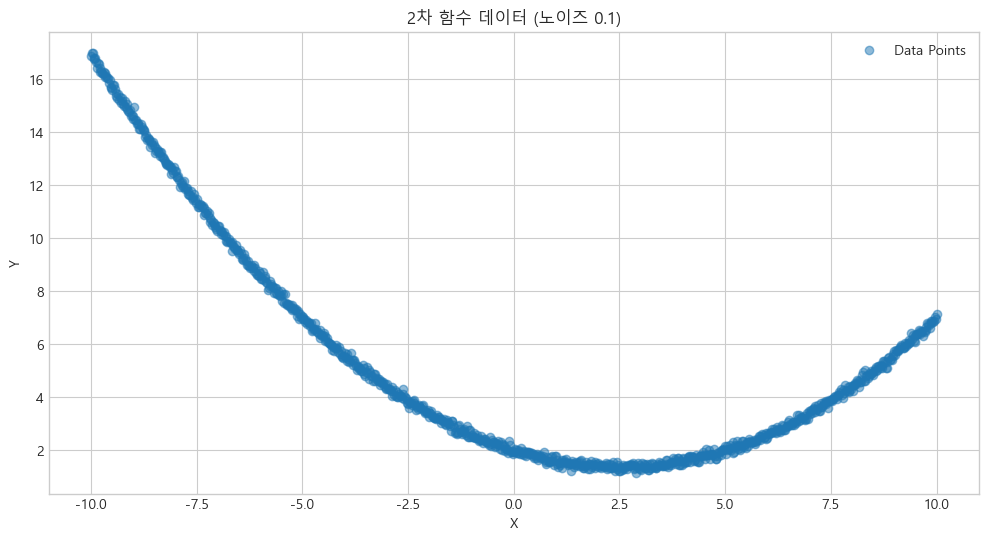

In [8]:
# 함수 시각화
plt.figure(figsize=(12, 6))
data = generate_2d_data(N_SAMPLES, 0.1)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data Points')
plt.title('2차 함수 데이터 (노이즈 0.1)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## 3. 종합 결과 및 가설 검증

실험 결과를 바탕으로 '노이즈 수준이 증가할수록 최적 컴포넌트 개수는 감소한다'는 핵심 가설을 검증합니다.

--- 종합 실험 결과 ---
   noise_level  mean_k_opt  std_k_opt
0          0.1   11.466667   0.805536
1          1.0    4.900000   0.395811
2          5.0    3.233333   0.422953
3         10.0    3.633333   0.795124
4         20.0    4.200000   2.797618
5         50.0    1.000000   0.000000


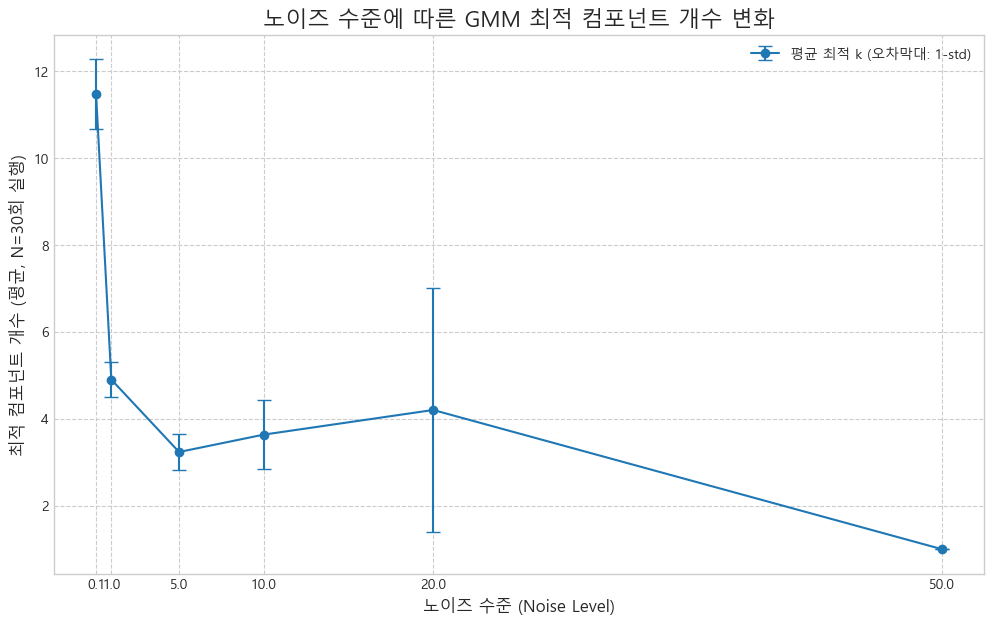

In [4]:
print("--- 종합 실험 결과 ---")
print(results_df)

plt.figure(figsize=(12, 7))
plt.errorbar(
    results_df['noise_level'], 
    results_df['mean_k_opt'], 
    yerr=results_df['std_k_opt'],
    fmt='-o', 
    capsize=5,
    label='평균 최적 k (오차막대: 1-std)'
)
plt.title('노이즈 수준에 따른 GMM 최적 컴포넌트 개수 변화', fontsize=16)
plt.xlabel('노이즈 수준 (Noise Level)', fontsize=12)
plt.ylabel(f'최적 컴포넌트 개수 (평균, N={N_RUNS}회 실행)', fontsize=12)
plt.xticks(NOISE_LEVELS)
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

## 4. 대표 사례 심층 분석

특정 노이즈 수준의 사례를 깊이 분석하여, GMM이 '어떻게' 그리고 '왜' 해당 복잡도를 최적으로 선택했는지 시각적으로 확인합니다. 이 섹션에서는 평가지표 분석과 컴포넌트 시각화를 통합하여 수행합니다.


--- 심층 분석 시작 (Noise Level = 10.0) ---


Finding best k for Noise 10.0:   0%|          | 0/25 [00:00<?, ?it/s]

분석 결과: BIC 기준 최적 k는 5 (type=int) 입니다.


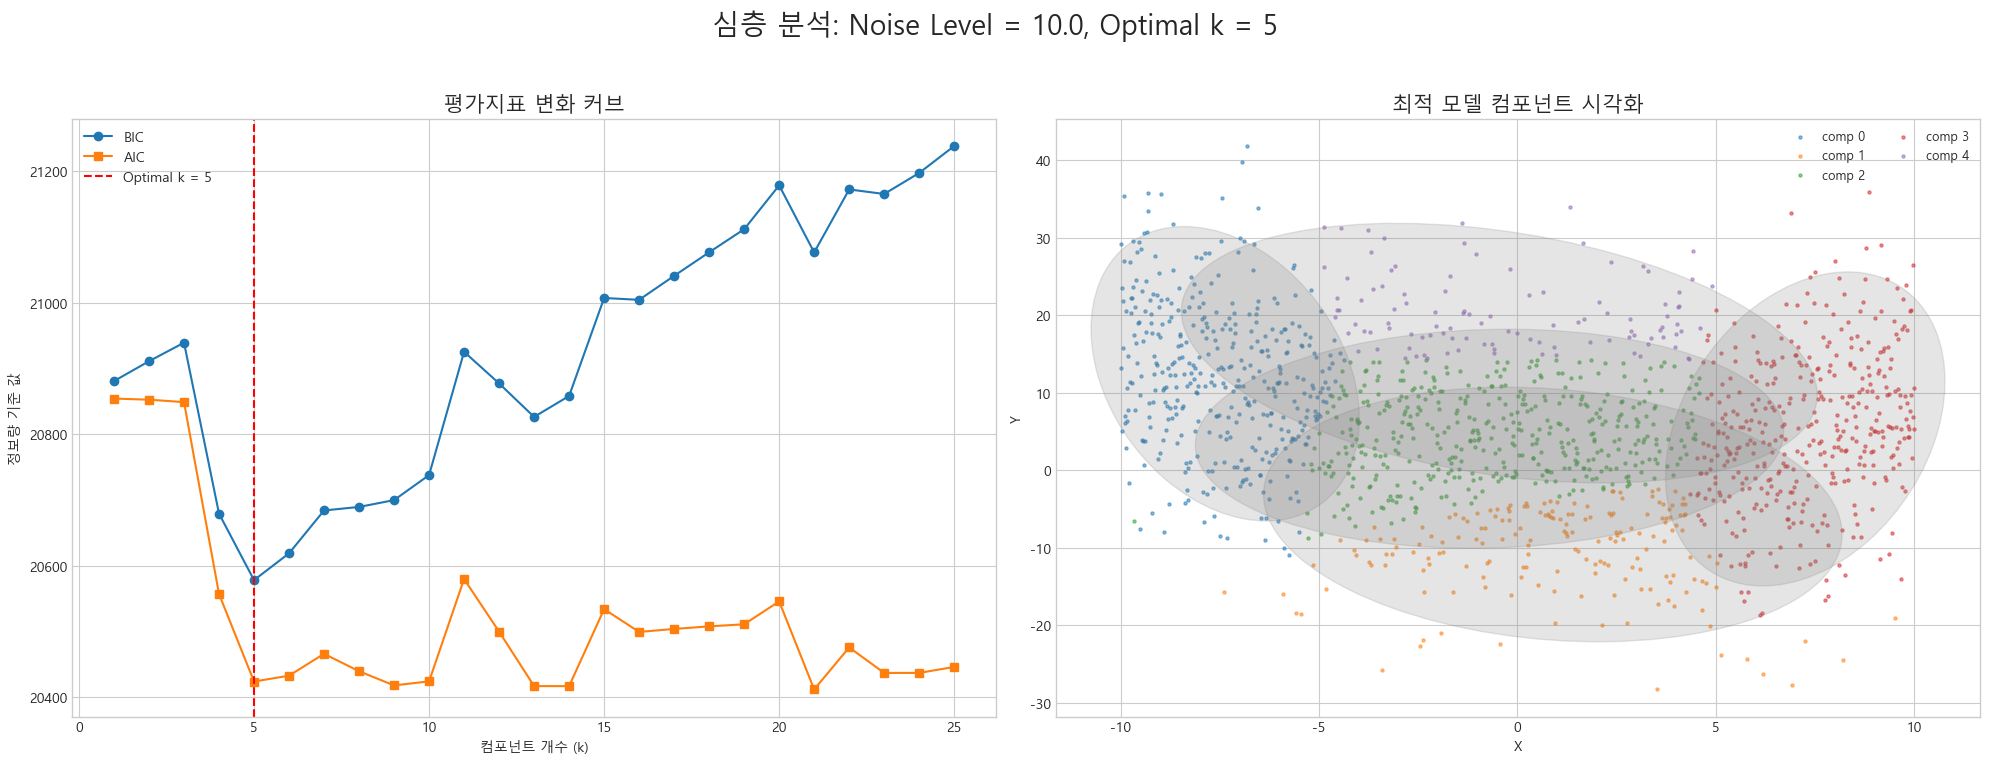

In [7]:
def analyze_and_visualize_representative_case(noise_level):
    """특정 노이즈 수준에 대해 심층 분석 및 시각화를 수행하는 통합 함수"""
    
    print(f"\n--- 심층 분석 시작 (Noise Level = {noise_level}) ---")
    # 1. 대표 데이터 생성
    data = generate_2d_data(1500, noise_level)
    
    # 2. 평가지표 계산 및 최적 k 찾기
    metrics = {'k': [], 'bic': [], 'aic': [], 'log_likelihood': []}
    for k in tqdm(N_COMPONENTS_RANGE, desc=f"Finding best k for Noise {noise_level}"):
        gmm = GaussianMixture(n_components=k, random_state=42, reg_covar=1e-6).fit(data)
        metrics['k'].append(int(k))  # 보장: int
        metrics['bic'].append(gmm.bic(data))
        metrics['aic'].append(gmm.aic(data))
        metrics['log_likelihood'].append(gmm.score(data) * len(data))
    
    metrics_df = pd.DataFrame(metrics)
    # idxmin() 결과에서 'k' 컬럼 값을 안전하게 int로 캐스팅
    best_k = int(metrics_df.loc[metrics_df['bic'].idxmin(), 'k'])
    if best_k < 1:
        best_k = 1  # 방어
    print(f"분석 결과: BIC 기준 최적 k는 {best_k} (type={type(best_k).__name__}) 입니다.")

    # 3. 평가지표 커브 시각화
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'심층 분석: Noise Level = {noise_level}, Optimal k = {best_k}', fontsize=20)
    
    axes[0].plot(metrics_df['k'], metrics_df['bic'], 'o-', label='BIC')
    axes[0].plot(metrics_df['k'], metrics_df['aic'], 's-', label='AIC')
    axes[0].axvline(best_k, color='red', linestyle='--', label=f'Optimal k = {best_k}')
    axes[0].set_title('평가지표 변화 커브', fontsize=15)
    axes[0].set_xlabel('컴포넌트 개수 (k)')
    axes[0].set_ylabel('정보량 기준 값')
    axes[0].legend()

    # 4. 최종 모델 컴포넌트 시각화 (best_k는 이제 확실한 int)
    gmm_final = GaussianMixture(n_components=best_k, random_state=42, reg_covar=1e-6).fit(data)
    labels = gmm_final.predict(data)
    
    for i in range(best_k):
        axes[1].scatter(data[labels == i, 0], data[labels == i, 1], s=5, alpha=0.5, label=f'comp {i}')
    
    # 타원 그리기 헬퍼
    def draw_ellipse(position, covariance, ax, **kwargs):
        if covariance.ndim == 1:
            covariance = np.diag(covariance)
        vals, vecs = np.linalg.eigh(covariance)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals) * 2
        ax.add_patch(Ellipse(xy=position, width=width, height=height, angle=angle, **kwargs))
        
    for i in range(best_k):
        draw_ellipse(gmm_final.means_[i], gmm_final.covariances_[i], ax=axes[1], alpha=0.2, color='gray')
    
    axes[1].set_title('최적 모델 컴포넌트 시각화', fontsize=15)
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].legend(loc='best', fontsize=9, ncol=2)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 대표 사례 실행 (노이즈 수준 10)
analyze_and_visualize_representative_case(noise_level=10.0)

## 5. 최종 결론

본 연구를 통해 데이터의 노이즈 수준과 GMM의 최적 복잡도 사이에 명확한 음의 상관관계가 존재함을 통계적, 시각적으로 검증하였다. 노이즈가 적은 환경에서는 데이터의 미세 구조를 포착하기 위해 복잡한 모델(많은 k)이 요구되는 반면, 노이즈가 많은 환경에서는 데이터의 전반적인 분포를 설명하는 단순한 모델(적은 k)이 더 효율적임이 BIC를 통해 확인되었다. 이러한 발견은 GMM 모델링 시 데이터의 품질을 고려하여 하이퍼파라미터 탐색 범위를 설정하는 데 중요한 실용적 가이드라인을 제공한다.